In [1]:
%load_ext autoreload
%autoreload 2

In [234]:
from scraper_utils import *
from kg_utils import *
from viz_utils import *

In [239]:
wiki_data = wiki_scrape('Bayer')
wiki_data.reset_index(drop=True, inplace=True)

In [240]:
wiki_data

page  \
0                              Bayer   
1    Banco Bilbao Vizcaya Argentaria   
2                        Lipofection   
3                       Imidacloprid   
4                     United Kingdom   
..                               ...   
481                          Xarelto   
482                      Chloroquine   
483                     Lepidopteran   
484                      Aflibercept   
485                         Oncology   

                                                  text  \
0    Bayer AG (; German: [ˈbaɪɐ]) is a German multi...   
1    Banco Bilbao Vizcaya Argentaria, S.A. (Spanish...   
2    Transfection is the process of deliberately in...   
3    Imidacloprid is a systemic insecticide that ac...   
4    The United Kingdom of Great Britain and Northe...   
..                                                 ...   
481  Rivaroxaban, sold under the brand name Xarelto...   
482  Chloroquine is a medication primarily used to ...   
483  Lepidoptera ( LEP-i-DOP-tər-ə, from Ancient Gr...   
484  Aflibercept, sold under the brandname Eylea an...   
485  Oncology is a branch of medicine that deals wi...   

                                                  link  \
0                  https://en.wikipedia.org/wiki/Bayer   
1    https://en.wikipedia.org/wiki/Banco_Bilbao_Viz...   
2           https://en.wikipedia.org/wiki/Transfection   
3           https://en.wikipedia.org/wiki/Imidacloprid   
4         https://en.wikipedia.org/wiki/United_Kingdom   
..                                                 ...   
481          https://en.wikipedia.org/wiki/Rivaroxaban   
482          https://en.wikipedia.org/wiki/Chloroquine   
483          https://en.wikipedia.org/wiki/Lepidoptera   
484          https://en.wikipedia.org/wiki/Aflibercept   
485             https://en.wikipedia.org/wiki/Oncology   

                                            categories  
0    [1863 establishments in Germany, Agriculture c...  
1    [1999 establishments in Spain, All articles co...  
2    [Applied genetics, Articles with short descrip...  
3    [All articles to be expanded, All articles wit...  
4    [All articles containing potentially dated sta...  
..                                                 ...  
481  [3-(4-methoxyphenyl)-2-oxazolidinones, All art...  
482  [1934 introductions, All articles that may con...  
483  [All articles with dead external links, Articl...  
484  [All articles containing potentially dated sta...  
485  [All articles with unsourced statements, All p...  

[486 rows x 4 columns]

In [136]:
# Pages from which we extract domain-specific whitelisted categories, in order to discard irrelevant pages
page_whitelist = ["Bayer", "Pharmaceutical industry"]

# Irrelevant pages which we know we want to ignore
page_blacklist = ["Auschwitz concentration camp", "Bayer 04 Leverkusen", "Monowitz concentration camp",
                  "TSV Bayer 04 Leverkusen", "KFC Uerdingen 05", ]

# Categories which we know are not relevant for the given domain
# These blacklisted categories are an irrelevant subset of categories from whitelisted pages
# All other categories from whitelisted pages are used to build the category whitelist
cat_blacklist = ["All articles", "Articles", "CS1", "Pages", "Portal", "Use dmy dates", 
                 "USA-centric", "Webarchive", "Wikipedia", "Wikidata", "Good articles", 
                 "Germany", "German", "Leverkusen", "Rhine", "factual verification", "RTT",
                 "Euro Stoxx 50", "Stock Exchange", "Holocaust", "changes to watched fields"] 

# Build category whitelist using pages whitelist and category blacklist
cat_whitelist = build_category_whitelist(wiki_data, page_whitelist, cat_blacklist)

# List of domain-specific entities which Spacy tools do not recognize as Named entities or Nouns chunks
global_ents_list = [title.lower() for title in wiki_data.page]

subj_freq_thresh = 20  # Threshold for pruning infrequently occuring subjects from KG
obj_freq_thresh = 10  # Threshold for pruning infrequently occuring objects from KG

In [241]:
wiki_triplets = pd.DataFrame(columns=['subject', 'relation', 'object'])
for idx in range(len(wiki_data)-1):
    title = wiki_data.page[idx]
    text = wiki_data.text[idx]
    cats = wiki_data.categories[idx]
    
    # Determine page relevance/whether we want to use it in KG
    is_relevant = False
    if title not in page_blacklist:
        for cat in cats:
            # If any page category is in the whitelise, use it
            if cat in cat_whitelist:
                is_relevant = True
                break

    if is_relevant:
        print(title)
        # Extract S-R-O triplets
        triplets = extract_triplets(text, title, global_ents_list)
        # Merge duplicate subjects and extensions of the title
        triplets = merge_duplicate_subjs(triplets, title)
        wiki_triplets = wiki_triplets.append(triplets, ignore_index=True)

# Prune graph nodes using heuristics
wiki_triplets = prune_infreq_subjects(wiki_triplets, threshold=subj_freq_thresh)
wiki_triplets = prune_infreq_objects(wiki_triplets, threshold=obj_freq_thresh)
wiki_triplets = prune_self_loops(wiki_triplets)

Bayer


100%|██████████| 348/348 [00:05<00:00, 68.11it/s]


Sanofi


100%|██████████| 186/186 [00:02<00:00, 67.57it/s]


Felix Hoffmann


100%|██████████| 35/35 [00:00<00:00, 56.70it/s]


Innovative Medicines Initiative


100%|██████████| 30/30 [00:00<00:00, 67.10it/s]


EFPIA


100%|██████████| 69/69 [00:00<00:00, 74.72it/s]


SmithKline Beecham


100%|██████████| 277/277 [00:04<00:00, 57.16it/s]


ASML Holding


100%|██████████| 38/38 [00:00<00:00, 59.02it/s]


Aspirin


100%|██████████| 319/319 [00:05<00:00, 60.93it/s]


Fresenius (company)


100%|██████████| 78/78 [00:01<00:00, 72.60it/s]


Bayer Aspirin


100%|██████████| 348/348 [00:05<00:00, 65.23it/s]


Agfa-Gevaert


100%|██████████| 258/258 [00:02<00:00, 88.07it/s]


Plant Genetic Systems


100%|██████████| 28/28 [00:00<00:00, 76.02it/s]


Acetylsalicylic acid


100%|██████████| 319/319 [00:04<00:00, 70.21it/s]


Life sciences


100%|██████████| 119/119 [00:01<00:00, 67.19it/s]


Genetically modified crops


100%|██████████| 406/406 [00:05<00:00, 70.57it/s]


Pharmaceutical industry


100%|██████████| 320/320 [00:05<00:00, 61.81it/s]


Sterling Drug


100%|██████████| 41/41 [00:00<00:00, 74.02it/s]


Roche Pharmaceuticals


100%|██████████| 196/196 [00:02<00:00, 78.08it/s]


Pre-clinical development


100%|██████████| 41/41 [00:00<00:00, 85.68it/s]


Bayer


100%|██████████| 348/348 [00:04<00:00, 71.86it/s]


Biotechnology


100%|██████████| 180/180 [00:02<00:00, 70.07it/s]


Merck & Co.


100%|██████████| 239/239 [00:03<00:00, 68.57it/s]


Merck & Co


100%|██████████| 239/239 [00:04<00:00, 53.77it/s]


Pharmaceutical company


100%|██████████| 320/320 [00:05<00:00, 57.38it/s]


Pharmaceutical companies


100%|██████████| 320/320 [00:05<00:00, 63.30it/s]


IG Farben Trial


100%|██████████| 81/81 [00:01<00:00, 59.45it/s]


Arthur Eichengrün


100%|██████████| 71/71 [00:00<00:00, 72.22it/s]


Monsanto


100%|██████████| 459/459 [00:06<00:00, 70.30it/s]


Cassella Farbwerke Mainkur Aktiengesellschaft


100%|██████████| 42/42 [00:00<00:00, 66.89it/s]


Hoffmann-La Roche


100%|██████████| 196/196 [00:02<00:00, 81.00it/s]


Hoechst AG


100%|██████████| 42/42 [00:00<00:00, 76.21it/s]


Jenapharm


100%|██████████| 83/83 [00:01<00:00, 64.59it/s]


BASF


100%|██████████| 208/208 [00:02<00:00, 75.47it/s]


Sterling Winthrop


100%|██████████| 41/41 [00:00<00:00, 76.28it/s]


IG Farben Building


100%|██████████| 171/171 [00:02<00:00, 80.39it/s]


Bayer AG


100%|██████████| 348/348 [00:04<00:00, 74.06it/s]


Miles Laboratories


100%|██████████| 23/23 [00:00<00:00, 71.11it/s]


IG Farben


100%|██████████| 228/228 [00:03<00:00, 63.05it/s]


Alka-Seltzer


100%|██████████| 92/92 [00:01<00:00, 74.99it/s]


List of life sciences


100%|██████████| 119/119 [00:01<00:00, 70.12it/s]


Schering AG


100%|██████████| 30/30 [00:00<00:00, 73.85it/s]


In [242]:
wiki_triplets

subject                                           relation  \
0       bayer                                              ag be   
2       bayer  area business include human veterinary pharmac...   
6       bayer                                       know product   
10      bayer                     be chemical company merge form   
11      bayer                                         merge form   
...       ...                                                ...   
11870    life  list  sciences include genetic modification sy...   
11887    life                                list  sciences call   
11889    life  list  sciences have experience steady strong g...   
12002    life                                list  sciences vary   
12004    life                                list  sciences read   

              object  
0             german  
2              seeds  
6            aspirin  
10         ig farben  
11         ig farben  
...              ...  
11870        biology  
11887  biotechnology  
11889        biology  
12002           time  
12004           time  

[1694 rows x 3 columns]

In [246]:
pd.options.display.max_rows = 100
wiki_triplets[wiki_triplets.subject=="bayer"][:100]

subject                                           relation  \
0     bayer                                              ag be   
2     bayer  area business include human veterinary pharmac...   
6     bayer                                       know product   
10    bayer                     be chemical company merge form   
11    bayer                                         merge form   
15    bayer               split constituent company 1951 split   
18    bayer                                            acquire   
20    bayer                                            acquire   
21    bayer        cropscience develop genetically modify crop   
22    bayer                                        modify crop   
40    bayer     major product be acetylsalicylic acid describe   
46    bayer                  produce each 10–20 tablet consume   
49    bayer                                chemist be discover   
50    bayer                                           discover   
54    bayer                                chemist have invent   
55    bayer                                             invent   
56    bayer                 be person use new formulation test   
57    bayer                           contend aspirin discover   
58    bayer                                               help   
69    bayer                                         confiscate   
77    bayer                                             become   
84    bayer                                  relinquish reward   
90    bayer      parent company use slave labour factory build   
91    bayer                                              build   
94    bayer                                     include 30,000   
97    bayer                                     employee write   
99    bayer                           obtain conclusive result   
102   bayer                                     build maintain   
103   bayer               split constituent company 1951 split   
119   bayer                                           withdraw   
130   bayer                                         be produce   
143   bayer  maker blood product agree pay $ settle case be...   
144   bayer   pay $ settle case behalf more hemophiliac infect   
150   bayer                                               sell   
153   bayer                                                 do   
161   bayer                                 be later introduce   
190   bayer                                            approve   
194   bayer                                   regard potential   
196   bayer                           increase risk blood clot   
198   bayer                           associate death 23 woman   
199   bayer                                               lead   
202   bayer                             obtain different study   
203   bayer                             add warning label 2012   
208   bayer                                       belong raise   
210   bayer                                                use   
214   bayer  scientists fail reveal result ongoing large st...   
215   bayer          reveal result ongoing large study suggest   
217   bayer                                             accord   
218   bayer                                   remain anonymous   
219   bayer                                            provide   
225   bayer  limit bleeding coronary bypass surgery cite fl...   
238   bayer  market cereal crop fresh produce fungal bacter...   
258   bayer  increase scrutiny neonicotinoid environmental ...   
260   bayer                                            be link   
264   bayer                                 discover scientist   
271   bayer                              market otc medication   
281   bayer  respond white knight bid july acquire majority...   
291   bayer                                            acquire   
292   bayer                                          agree buy   
293   bayer                                 

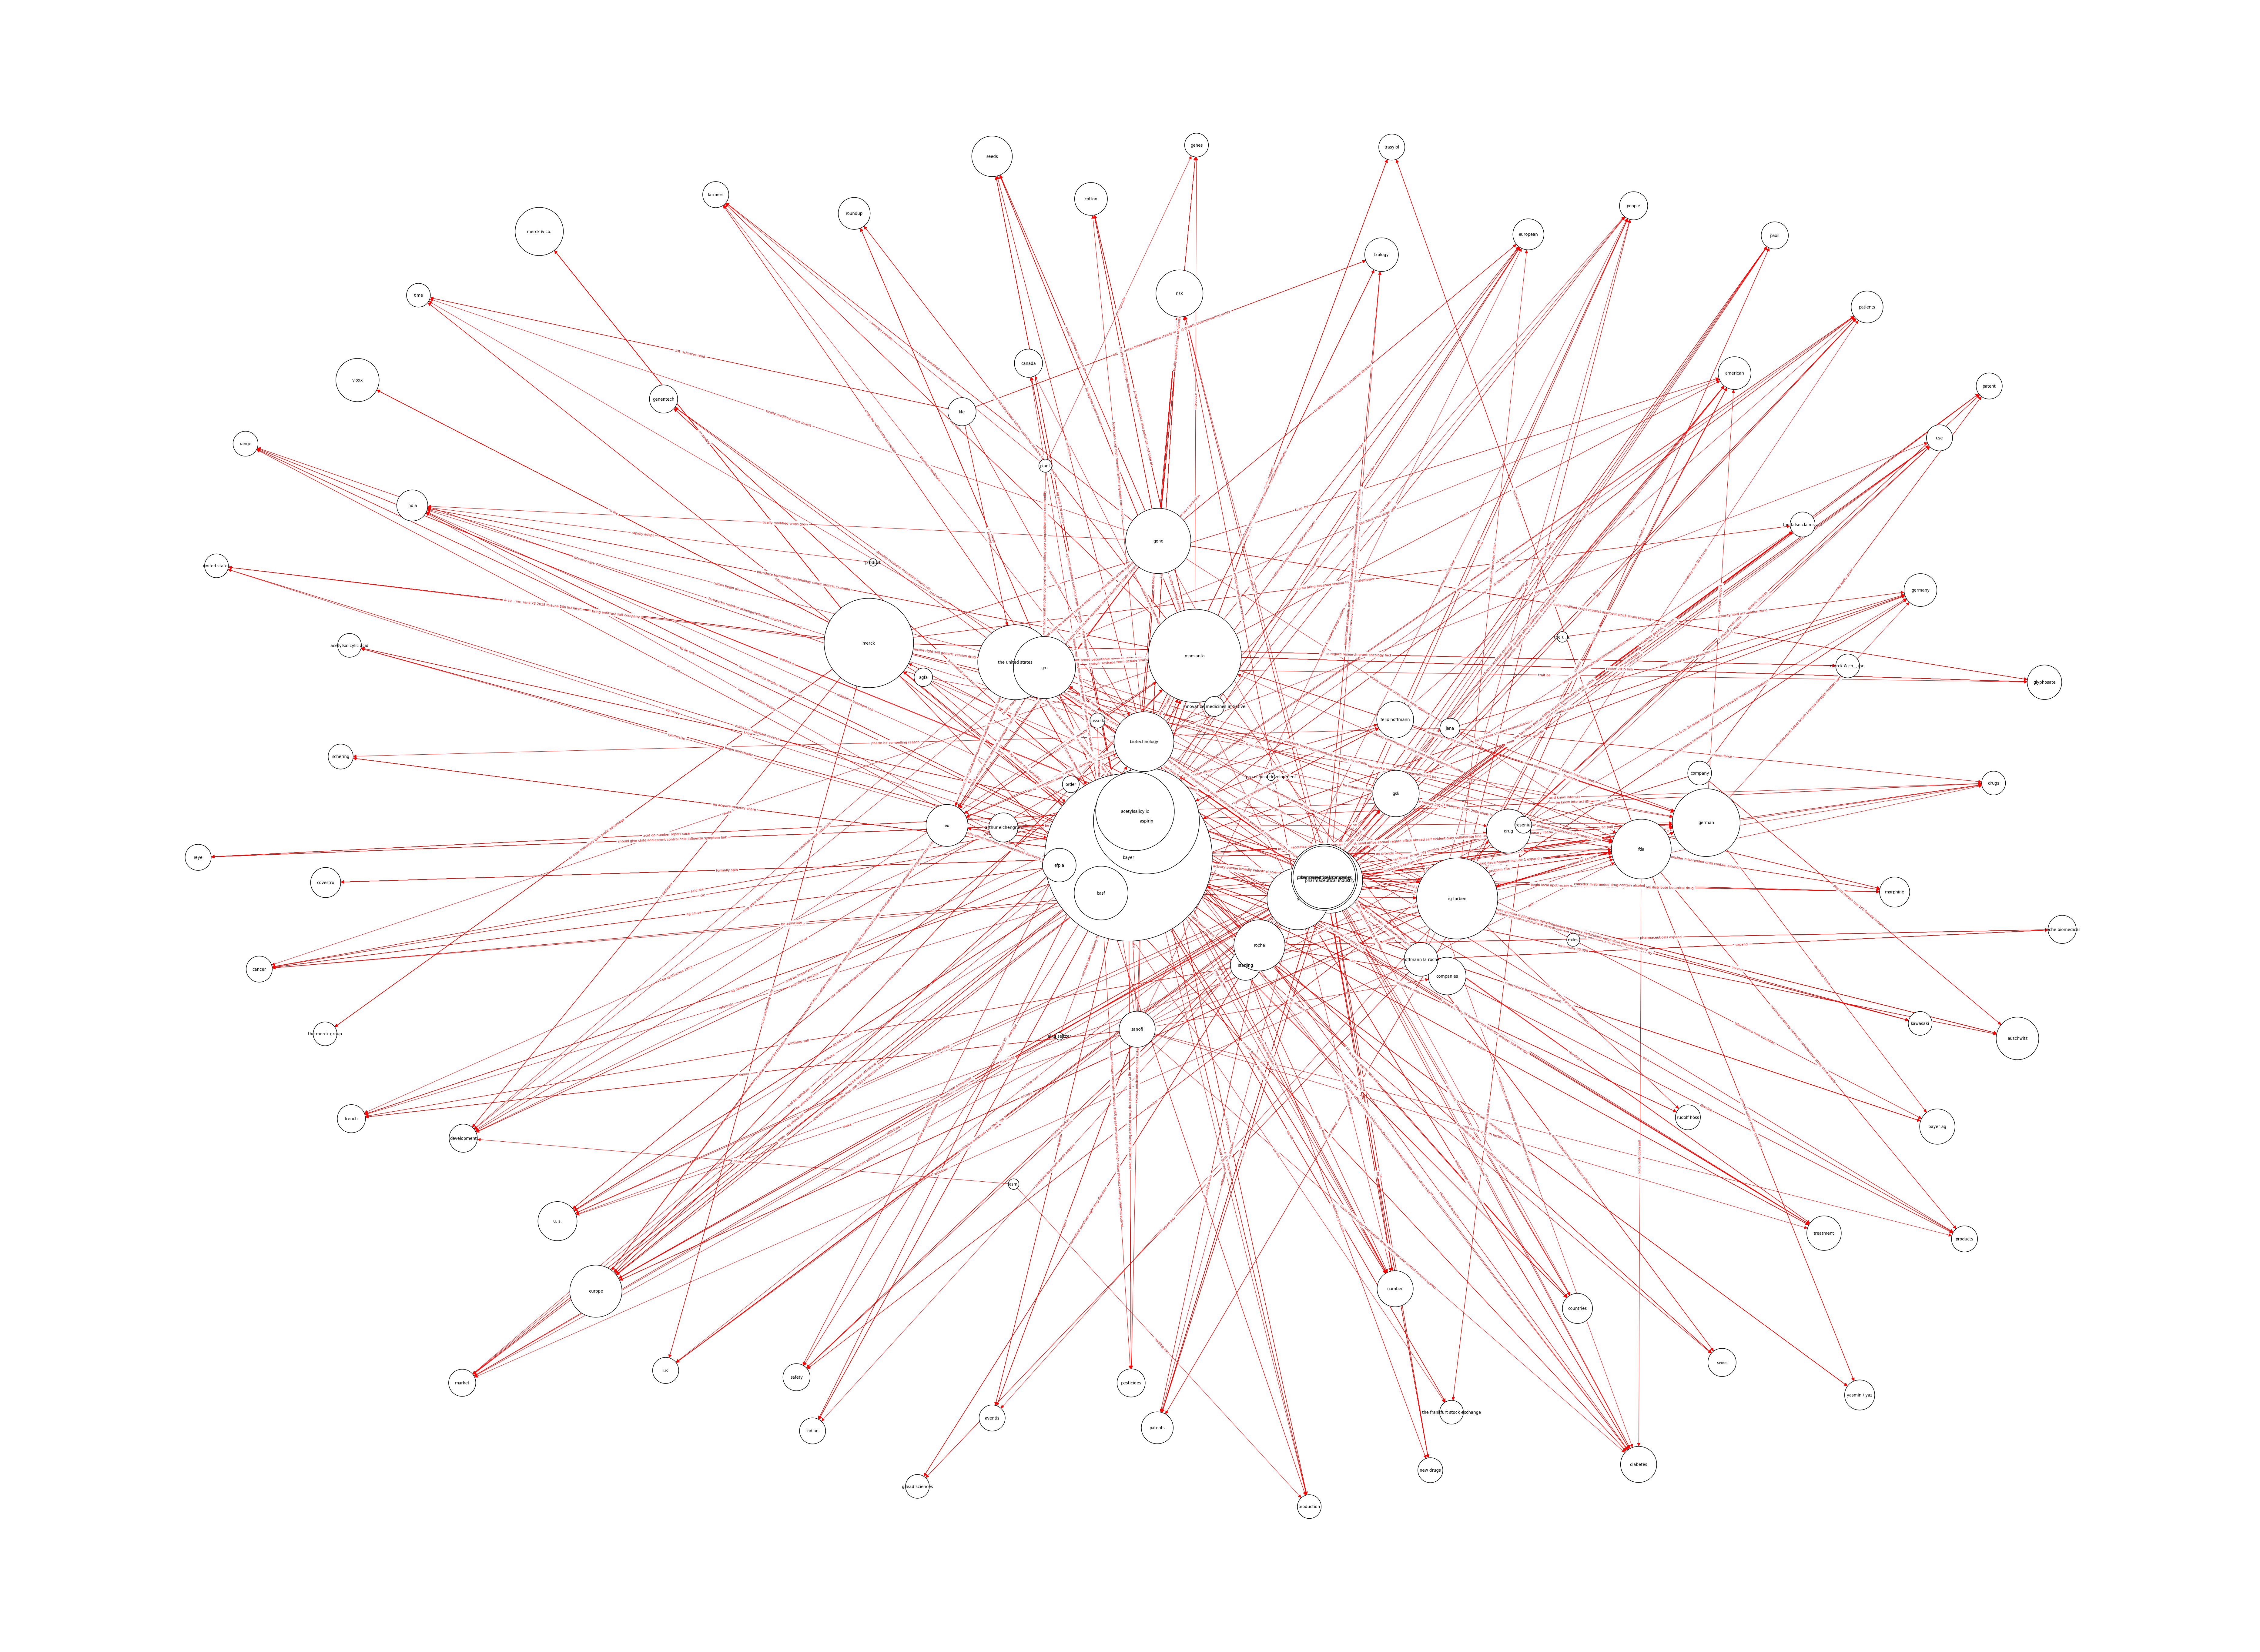

In [244]:
draw_kg(wiki_triplets)


S-R-O:
 bayer - pharmaceutica insecticide chairman request head office abroad regard office abroad self evident duty collaborate fine understanding manner functionary liberal - german

S-R-O:
 bayer - ag limit bleeding coronary bypass surgery cite flaw design study lead - canada

S-R-O:
 bayer - ag buy - merck

S-R-O:
 bayer - ag help - felix hoffmann

S-R-O:
 bayer - formally spin - covestro

S-R-O:
 bayer - ag acquire majority share - schering

S-R-O:
 bayer - ag be divide evenly - companies

S-R-O:
 felix hoffmann - claim inventor aspirin    footnote - german

S-R-O:
 felix hoffmann - synthesize acetylsalicylic acid    work - bayer

S-R-O:
 companies - include - bayer


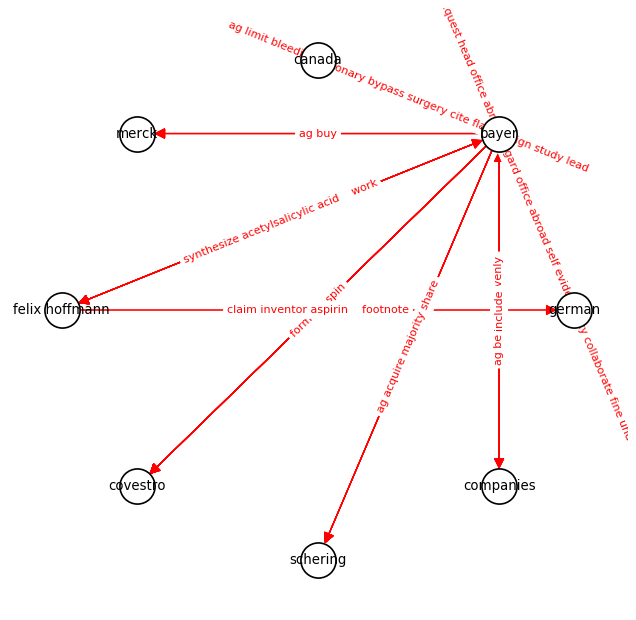

In [248]:
draw_kg_subgraph(wiki_triplets, 'bayer', n_hops=1)

In [14]:
# from transformers import AutoModelForTokenClassification, AutoTokenizer
# import torch

# model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# label_list = [
#     "O",       # Outside of a named entity
#     "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
#     "I-MISC",  # Miscellaneous entity
#     "B-PER",   # Beginning of a person's name right after another person's name
#     "I-PER",   # Person's name
#     "B-ORG",   # Beginning of an organisation right after another organisation
#     "I-ORG",   # Organisation
#     "B-LOC",   # Beginning of a location right after another location
#     "I-LOC"    # Location
# ]

# sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
#            "close to the Manhattan Bridge."

# # Bit of a hack to get the tokens with the special tokens
# tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
# inputs = tokenizer.encode(sequence, return_tensors="pt")

# outputs = model(inputs)[0]
# predictions = torch.argmax(outputs, dim=2)

# print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])

In [15]:
# sequence = "Headquartered in Leverkusen, Bayer's areas of business include human and veterinary pharmaceuticals; consumer healthcare products; agricultural chemicals, seeds and biotechnology products. Werner Baumann has been CEO since 2016."

# # Bit of a hack to get the tokens with the special tokens
# tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
# inputs = tokenizer.encode(sequence, return_tensors="pt")

# outputs = model(inputs)[0]
# predictions = torch.argmax(outputs, dim=2)

# print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])